In [1]:
import numpyro
import numpyro.distributions as dist
from numpyro.contrib.control_flow import scan
from numpyro.infer import MCMC, NUTS
from numpyro.infer import Predictive
numpyro.enable_x64()    

import arviz as az
import jax
import jax.numpy as jnp
from jax import random
import jax.random as random
from tqdm import tqdm
import pandas as pd
import numpy as np
import re
from datetime import datetime
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
from matplotlib.lines import Line2D

import seaborn as sns
import warnings
warnings.simplefilter('ignore')


class ProgressBar:
    def __init__(self, total):
        self.pbar = tqdm(total=total, desc="Sampling Progress", position=0, leave=True)

    def update(self, value):
        self.pbar.update(value)

    def close(self):
        self.pbar.close()

def get_model_number(model_str):
    nums = re.findall(r'\d+', model_str)
    if nums:
        return int(nums[-1])
    else:
        return None
colors = ['black', 'blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']

# --------------------------------------------------------
# global style
# --------------------------------------------------------
mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 12,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "lines.linewidth": 1.5,
    "axes.grid": True,
    "grid.alpha": 0.3,
})

# --------------------------------------------------------
# helper: draw one decomposition in an existing Axes
# --------------------------------------------------------
def plot_decomposition_ax(ax, date, original, trend, cycle, title, loc="upper left"):
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

    # level & trend  ------------------------
    ax.plot(date, original, label="Original", color=colors[0])
    ax.plot(date, trend,    label="Trend",    color=colors[1])
    ax.set_xlabel("Year")
    ax.set_ylabel("level / trend")
    ax.set_title(title)
    ax.grid(True, linestyle="--", alpha=0.4)

    # cycle (twin axis) ---------------------
    ax2 = ax.twinx()
    ax2.plot(date, cycle, label="Cycle", color=colors[2])
    ax2.axhline(0, color="gray", linestyle="--", linewidth=1)
    ax2.set_ylabel("Cycle")
    ax2.tick_params(axis="y", colors=colors[2])

    # legend (combine both axes) ------------
    lines  = ax.get_lines() + ax2.get_lines()
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc=loc, frameon=False)


/Users/satoshan/.pyenv/versions/miniforge3-4.10.3-10/envs/forpymc/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# De-trended Markup data
data_markup_BN = pd.read_csv("../data/BN_markup.csv")
data_markup_BN['markup_BN'] = data_markup_BN["cycle"] 
data_markup_BN['DATE'] = data_markup_BN["date"]
data_markup_BN = data_markup_BN[["DATE", "markup_BN"]].dropna()
data_markup_BN['DATE'] = pd.to_datetime(data_markup_BN['DATE'])
data_markup_BN

,DATE,markup_BN
0,1947-01-01,-0.342887
1,1947-04-01,-1.781127
2,1947-07-01,-1.310880
3,1947-10-01,-0.463812
4,1948-01-01,1.950659
...,...,...
279,2016-10-01,-1.112968
280,2017-01-01,-1.863219
281,2017-04-01,-1.170720
282,2017-07-01,-1.324781


## Estimation

NKPC under HSA

$$
\hat{\pi}_{t}=\beta\left(1-\delta\right)\mathbb{E}_{t}\hat{\pi}_{t+1}+\overset{\text{steady-state effect}}{\overbrace{\frac{\zeta\left(z\right)-1}{\chi}}}\left(\hat{W}_{t}-\hat{Z}_{P,t}-\hat{p}_{t}\right)-\overset{\text{dynamic effect}}{\overbrace{\frac{1}{\chi}\frac{1-\rho\left(z\right)}{\rho\left(z\right)}\hat{N}_{t}}}
$$

Note that $s\left(z_{t}\right)=\frac{1}{N_{t}}$ and $Y_{t}=\frac{1}{\mu_{t}}=\left(\hat{W}_{t}-\hat{Z}_{P,t}-\hat{p}_{t}\right)$

Estimation strategy

$N_{t}$ denotes the measure of the number of firms (varieties), or the inverse of concentration, and $x_{t}$ denotes the measure of the output gap or the inverse of the markup.

---
---
# Estimation strategies (3 patterns)
### NKPC under CES (Benchmark)
$s(z_t) = \gamma_{CES}(z_t)^{1−\theta}$

$\theta$ denotes the constant price elasticity, and $\zeta(z) = \theta$ and $\rho(z) = 1$:
$$
\pi_{t}=\alpha\pi_{t-1}+(1-\alpha)\mathbb{E}_{t}\pi_{t-1}+\underset{\kappa}{\underbrace{\frac{\theta-1}{\chi}}}x_{t}+v_{t}
$$
$$
v_t \sim \mathcal{N}(0, \sigma_{v}^2)
$$

Estimated parameters are $\alpha$, $\theta$, $\chi$ and $\sigma_{v}$.

$\chi$: scales the size of the cost

$\theta$: the constant price elasticity,


### NKPC under HSA

$$
\pi_{t}=\alpha\pi_{t-1}+(1-\alpha)\mathbb{E}_{t}\pi_{t+1}+\underset{\kappa}{\underbrace{\frac{\zeta(z)-1}{\chi}}}x_{t}-\underset{\theta}{\underbrace{\frac{1-\rho(z)}{\rho(z)\chi}}}\hat{N}_{t}+v_{t},
$$
$$
N_{t}=\bar{N}_{t}+\hat{N}_{t},
$$
where
$$
\hat{N}_{t}=\rho_1 \hat{N}_{t-1}+\rho_2 \hat{N}_{t-2}+\epsilon_{t}
$$
$$
\bar{N}_{t}=n+\bar{N}_{t-1}+\eta_{t},
$$

$$
v_t \sim \mathcal{N}(0, \sigma_{v}^2), \quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2), \quad \eta_t \sim \mathcal{N}(0, \sigma_{v}^2)
$$

Estimated parameters are $\alpha$, $\kappa$, $\theta$, $\rho_1$, $\rho_2$, $n$, $\psi$,  $\sigma_{v}$, $\sigma_{\epsilon}$, and $\sigma_{\eta}$.

$\zeta(z) = 1-\frac{s′(z)z}{s(z)}$ : the price elasticity function $\zeta(z) > 1$

$\rho(z)=[1-\frac{dln(\frac{\zeta(z)}{\zeta(z)-1})}{dln(z)}]^{-1}$   : the pass-through rate function, $1 >\rho(z) > 0$



## Restrictions on the estimation strategies
$0<\alpha<1$,

$0<\kappa$,  

$0<\theta$

$0<\psi$ 

$\rho_1$ and $\rho_2$ must satisfy 

$\rho_2 - \rho_1 < 1$

$\rho_2 + \rho_1 < 1$

$|\rho_2| < 1$

To satisfy $\rho$ restrictions, 
we set prior for $\rho_1$ as a uniform distribution over $(0,2)$ and prior for $\rho_2$ as a uniform distribution over $(-1,0)$.

In addition, we don't adopt pairs of $\rho_1$ and $\rho_2$ which is not satisfying $\rho$ restrictions.



Another way:
we first sample the damping factor ($-1<r<1$) and frequency of the cycle($0<p<1$) and then calculate $\rho_1 = 2rcos(\pi p)$ and $\rho_2 = -r^2$.

$z^2 - \rho_1 z - \rho_2=0$

$z_{1,2} = r e^{\pm i \pi p}$ 

Therefore, 

$\rho_1 = z_1 + z_2 = r e^{i \pi p} + r e^{-i \pi p}= 2 r \cos(\pi p)$

$\rho_2 = -z_1 z_2 = - r^2$

In [189]:
# cpi data
data_cpi = pd.read_csv("data/CPIAUCSL.csv", parse_dates=["DATE"])
data_cpi.set_index("DATE", inplace=True)
data_cpi = data_cpi.resample("QS").mean()
data_cpi['pi'] = data_cpi['CPIAUCSL'].pct_change() * 100
data_cpi = data_cpi['pi']
data_cpi = data_cpi.reset_index()
data_cpi['DATE'] = pd.to_datetime(data_cpi['DATE'])

# Markup data
data_markup = pd.read_excel("data/nekarda_ramey_markups.xlsx")
data_markup['DATE'] = pd.to_datetime(data_markup['qdate'], format='%Y-%m-%d')
data_markup['markup'] = data_markup['mu_bus']
data_markup = data_markup[['DATE', 'markup']].dropna()

# output gap data
data_output = pd.read_csv("data/BN_filter_GDPC1_quaterly.csv")
data_output['output_BN'] = data_output['GDPC1_transformed_series']
data_output['output_gap_BN'] = data_output["cycle"]
data_output['output'] = np.log(data_output["GDPC1_original_series"] * 0.01)
data_output['DATE'] = data_output["date"]
data_output["output_trend_BN"] = data_output["output_BN"] - data_output["output_gap_BN"]
data_output = data_output[["DATE", "output_BN", "output_gap_BN", "output_trend_BN", "output"]].dropna()
data_output['DATE'] = pd.to_datetime(data_output['DATE'])


# inflation expectation data
data_Epi = pd.read_csv("data/one_year_inflation_expectation.csv")
data_Epi['DATE'] = pd.to_datetime(data_Epi['Model Output Date'])
data_Epi.set_index("DATE", inplace=True)
data_Epi = data_Epi[[" 1 year Expected Inflation"]].resample("QS").mean() * 100 / 4
data_Epi['Epi'] = data_Epi[' 1 year Expected Inflation']
data_Epi = data_Epi.reset_index()
data_Epi = data_Epi[["DATE", "Epi"]]
data_Epi['DATE'] = pd.to_datetime(data_Epi['DATE'])

# HHI
data_N_annual = pd.read_excel("data/WITS-Country-Timeseries.xlsx")
data_N_annual["HHI"] = data_N_annual["Unnamed: 1"]
data_N_annual['year'] = pd.to_datetime(data_N_annual['year'], format='%Y') + pd.offsets.YearBegin(0)
data_N_annual = data_N_annual.set_index('year')
data_N = data_N_annual.resample('QS').asfreq()
data_N['HHI'] = data_N['HHI'].interpolate(method='linear')
data_N = data_N.reset_index()
data_N['DATE'] = pd.to_datetime(data_N['year'])
data_N = data_N[["DATE", "HHI"]]
data_N["N"] = np.log(1/data_N["HHI"]) 
data_N.to_csv("data/N_HHI.csv", index=False)

# Merge all dataframes
data = pd.merge(data_cpi, data_Epi, on="DATE", how="outer")
data = pd.merge(data, data_output, on="DATE", how="outer")
data = pd.merge(data, data_N, on="DATE", how="outer")
data = pd.merge(data, data_markup, on="DATE", how="outer")
data["output_gap_BN"] = data["output_gap_BN"]
data["markup"] = data["markup"]
data["N"] = data["N"]

data["pi_prev"] = data["pi"].shift(1)
data["output_gap_prev"] = data["output_gap_BN"].shift(1)
data["markup_prev"] = data["markup"].shift(1)
data['N_prev'] = data['N'].shift(1)
data = data.dropna()

# for MCMC
pi = jnp.array(data['pi'],dtype=jnp.float64)
pi_prev = jnp.array(data['pi_prev'],dtype=jnp.float64)
pi_expect = jnp.array(data['Epi'],dtype=jnp.float64)
N = jnp.array(data['N'],dtype=jnp.float64)
Y = jnp.array(data['output'],dtype=jnp.float64)
x_markup = jnp.array(1/data['markup'],dtype=jnp.float64)
x_output_gap = jnp.array(data['output_gap_BN'],dtype=jnp.float64)
x_output_gap_prev = jnp.array(data['output_gap_prev'],dtype=jnp.float64)
x_markup_prev = jnp.array(1/data['markup_prev'],dtype=jnp.float64)

# N_hat = jnp.array(data["N_hat"], dtype=jnp.float64)

In [205]:
warmup= 1000
samples=9000
chains = 2
rng_key = jax.random.PRNGKey(0)
rng_keys = jax.random.split(rng_key, chains)

def set_prior_distributions():
    priors = {
        # NKPC params
        "alpha"      : dist.Beta(2, 2),
        "kappa"      : dist.Beta(2, 2),
        "kappa_init" : dist.Beta(2, 2),
        "theta"      : dist.Beta(2, 2),
        "delta"      : dist.Beta(2, 2),
        "n"          : dist.Normal(0, 1), 
        # Sigma
        "sigma_u"    : dist.LogNormal(0, 1),  
        "sigma_eps"  : dist.LogNormal(0, 1),  
        "sigma_v"    : dist.LogNormal(0, 1),  
        "sigma_mu"   : dist.LogNormal(0, 1),  
        "sigma_e"    : dist.LogNormal(0, 1),  
        "sigma_eta"  : dist.LogNormal(0, 1),  
    }
    return priors

In [206]:
x = x_markup
x_prev = x_markup_prev

In [207]:
def model_0(pi, pi_prev, pi_expect, x):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha", priors["alpha"])
    kappa = numpyro.sample("kappa", priors["kappa"])
    # Sigma
    sigma_v = numpyro.sample("sigma_v", priors["sigma_v"])
    # model
    pi_pred = alpha * pi_prev + (1-alpha) * pi_expect + kappa * x
    numpyro.sample(f"pi_obs", numpyro.distributions.Normal(pi_pred, sigma_v), obs=pi)


# NKPC under CES =================================================
print("NKPC under CES")
kernel = NUTS(model_0, target_accept_prob=0.995)
mcmc_1 = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc_1.run(rng_keys, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, x=x)
idata_0 = az.from_numpyro(mcmc_1)
posterior_samples = mcmc_1.get_samples()
diverging  = idata_0.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()                             # mean of 0/1 booleans = share of divergences
print(f"model 0: divergence ratio = {ratio_div:.4%}")     # bool for each param

NKPC under CES


sample: 100%|██████████| 10000/10000 [00:04<00:00, 2355.67it/s, 15 steps of size 1.85e-01. acc. prob=0.99]


model 0: divergence ratio = 0.0000%


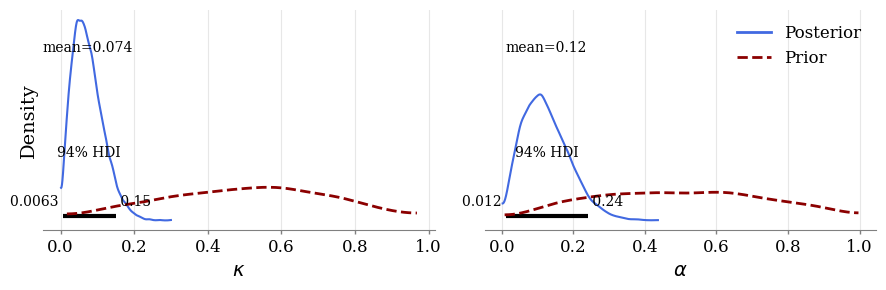

In [ ]:
rng = random.PRNGKey(123)
prior_pred = Predictive(model_0, num_samples=5000)
prior_draws = prior_pred(rng, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, x=x)
param_names = [ "alpha", "kappa"]
prior_dict = {k: v for k, v in prior_draws.items() if k in param_names}
idata_prior = az.from_dict(prior=prior_dict)

fig, axes = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
params = ["kappa", "alpha"]
labels = [r"$\kappa$", r"$\alpha$"]
for ax, param, label in zip(axes, params, labels):
    # Posterior
    az.plot_posterior(
        idata_0,
        var_names=[param],
        point_estimate="mean",
        hdi_prob=None,
        kind="kde",
        color="royalblue",
        ax=ax,
    )
    # Prior
    az.plot_dist(
        idata_prior.prior[param],
        ax=ax,
        color="darkred",
        fill_kwargs=None,
        plot_kwargs={"ls": "--", "lw": 2},
    )
    ax.set_title("")
    ax.set_xlabel(label, fontsize=14)
    ax.tick_params(axis="both", labelsize=12)
    
axes[0].set_ylabel("Density", fontsize=14)
axes[1].set_ylabel("")

legend_handles = [
    Line2D([0], [0], color="royalblue", lw=2, label="Posterior"),
    Line2D([0], [0], color="darkred", lw=2, ls="--", label="Prior"),
]
axes[1].legend(handles=legend_handles, fontsize=12, loc="upper right", frameon=False)

plt.tight_layout()
plt.show()

In [209]:
def model_1(pi, pi_prev, pi_expect, x, N, l):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha",priors["alpha"])
    kappa = numpyro.sample("kappa", priors["kappa"])
    theta = numpyro.sample("theta", priors["theta"])
    # State equation (N) params
    r = numpyro.sample("r", dist.Uniform(-1,1))      
    p = numpyro.sample("p", dist.Uniform(0.1, 0.9))  
    rho_1 = 2 * r * jnp.cos(jnp.pi * p)
    rho_2 = -r ** 2
    numpyro.deterministic("rho_1", rho_1) # Nhat AR1 coeff
    numpyro.deterministic("rho_2", rho_2) # Nhat AR2 coeff
    n = numpyro.sample("n", priors["n"])
    # Sigma
    sigma_v  = numpyro.sample("sigma_v", priors["sigma_v"])      
    sigma_u  = numpyro.sample("sigma_u", priors["sigma_u"])      
    sigma_eps = numpyro.sample("sigma_eps", priors["sigma_eps"]) 
    # initial 
    bar_N_0  = numpyro.sample("bar_N_0", dist.Normal(N[0], 1))   # Nbar init
    hat_N_0  = numpyro.sample("hat_N_0", dist.Normal(0, .05))    # Nhat init
    hat_N_1  = numpyro.sample("hat_N_1", dist.Normal(0, .05))    # Nhat init
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):
        Nbar_prev = carry[0]
        Nhat_prev_1 = carry[1]
        Nhat_prev_2 = carry[2]
        t = carry[3]
        # state equation
        # trend 
        Nbar_t = numpyro.sample("Nbar", dist.Normal(n + Nbar_prev, sigma_eps))
        # N (Nbar + Nhat = observed N)
        N_hat_obs = N[t] - Nbar_t
        # cycle
        N_hat_pred = rho_1 * Nhat_prev_1 + rho_2 * Nhat_prev_2
        Nhat_t = numpyro.sample("Nhat_t", dist.Normal(N_hat_pred, sigma_u), obs=N_hat_obs)
        numpyro.deterministic("Nhat", Nhat_t) 
        # pi
        pi_pred = alpha * pi_prev[t] + (1-alpha) * pi_expect[t] + kappa * x[t] - theta * Nhat_t
        numpyro.sample(f"pi_obs", dist.Normal(pi_pred, sigma_v), obs=pi[t])
        t = t + 1
        return [Nbar_t, Nhat_t, Nhat_prev_1 , t], None
    scan(transition, [bar_N_0, hat_N_0, hat_N_1, t], timesteps)

In [210]:
# NKPC under HSA : no shift in slope ==============================
print("NKPC under HSA : no shift in slope")
kernel = NUTS(model_1, target_accept_prob=0.95)
mcmc_1 = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc_1.run(rng_keys, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, x=x, N = N, l=len(pi))
idata_1 = az.from_numpyro(mcmc_1)
posterior_samples_1 = mcmc_1.get_samples()
N_bar_samples = posterior_samples_1["Nbar"]
N_bar_mean_1_m = np.mean(N_bar_samples, axis=0) 
N_bar_std_1_m = np.std(N_bar_samples, axis=0)  
N_bar_lower_1_m = N_bar_mean_1_m - 1.97 * N_bar_std_1_m
N_bar_upper_1_m = N_bar_mean_1_m + 1.97 * N_bar_std_1_m
N_hat_samples = posterior_samples_1["Nhat"]
N_hat_mean_1_m = np.mean(N_hat_samples, axis=0) 
N_hat_std_1_m = np.std(N_hat_samples, axis=0)  
N_hat_lower_1_m = N_hat_mean_1_m - 1.97 * N_hat_std_1_m
N_hat_upper_1_m = N_hat_mean_1_m + 1.97 * N_hat_std_1_m
diverging  = idata_1.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 1 : divergence ratio = {ratio_div:.4%}")

NKPC under HSA : no shift in slope


sample: 100%|██████████| 10000/10000 [06:29<00:00, 25.65it/s, 127 steps of size 3.34e-02. acc. prob=0.93]


Model 1 : divergence ratio = 0.0000%


In [211]:
dict_idata = {
    'NKPC: CES':idata_0, 'NKPC: HSA no-shift':idata_1,
    }

params = [
    "alpha", "kappa", "theta", "rho_1", "rho_2",  "n"
    ]
df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            if param in summary.index:
                row[param] = f"{summary.loc[param, 'mean']:.3f}"
            else:
                row[param] = "-"
        else:
            row[param] = "-"
    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)

,model,alpha,kappa,theta,rho_1,rho_2,n
0,NKPC: CES,0.124,0.074,-,-,-,-
1,NKPC: HSA no-shift,0.125,0.076,0.461,1.707,-0.809,0.005


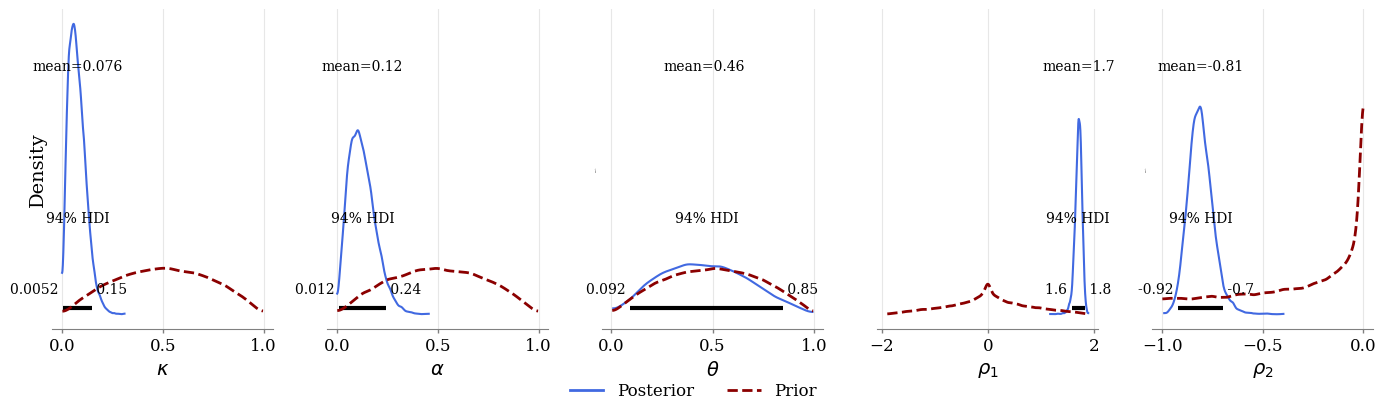

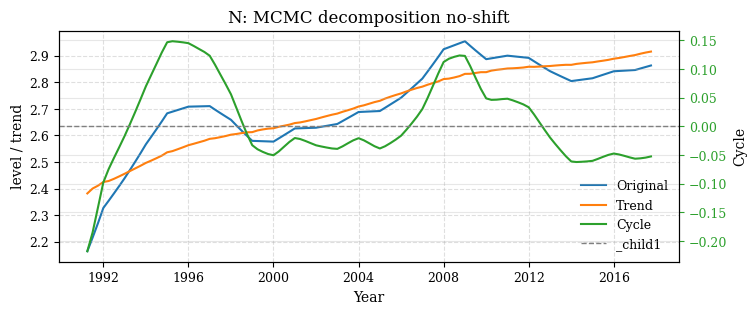

In [212]:
prior_pred_1 = Predictive(model_1, num_samples=50000)
prior_draws_1 = prior_pred_1(rng, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, x=x, N=N, l=len(pi))
params = ["kappa", "alpha", "theta", "rho_1", "rho_2"]
labels = [r"$\kappa$", r"$\alpha$", r"$\theta$", r"$\rho_{1}$", r"$\rho_{2}$"]

prior_dict_1 = {k: prior_draws_1[k] for k in params if k in prior_draws_1}
idata_prior_1 = az.from_dict(prior=prior_dict_1)

fig, axes = plt.subplots(1, 5, figsize=(14, 4), sharey=True)
axes_flat = axes.ravel()

for ax, param, label in zip(axes_flat, params, labels):
    az.plot_posterior(
        idata_1,
        var_names=[param],
        point_estimate="mean",
        hdi_prob=None,
        kind="kde",
        color="royalblue",
        ax=ax,
    )
    if hasattr(idata_prior_1, "prior") and (param in idata_prior_1.prior.data_vars):
        az.plot_dist(
            idata_prior_1.prior[param],
            ax=ax,
            color="darkred",
            fill_kwargs=None,
            plot_kwargs={"ls": "--", "lw": 2},
        )
    ax.set_title("")
    ax.set_xlabel(label, fontsize=14)
    ax.tick_params(axis="both", labelsize=12)

for i, ax in enumerate(axes_flat):
    ax.set_ylabel("Density", fontsize=14 if i % 5 == 0 else 0)
    if i % 2 == 1:
        ax.set_ylabel("")

for j in range(len(params), len(axes_flat)):
    axes_flat[j].axis("off")

legend_handles = [
    Line2D([0], [0], color="royalblue", lw=2, label="Posterior"),
    Line2D([0], [0], color="darkred",  lw=2, ls="--", label="Prior"),
]
fig.legend(
    handles=legend_handles,
    fontsize=12,
    loc="lower center",
    ncol=2,                 
    frameon=False,
    bbox_to_anchor=(0.5, -0.05)  
)
plt.tight_layout()
plt.show()

scale = 2
fig, axes = plt.subplots(1, 1, figsize=(8, 3), sharex=False)
# First decomposition: no shift
plot_decomposition_ax(
    axes,
    data["DATE"], data["N"], N_bar_mean_1_m, N_hat_mean_1_m,
    "N: MCMC decomposition no-shift", loc="lower right"
)

## Model Comparison

## WAIC
（Widely Applicable Information Criterion, Watanabe Akaike Information Criterion）is calculated by:
$$
\text{WAIC}=-2\Bigl(\text{lppd}-p_{\text{WAIC}}\Bigr)
$$
where
- log pointwise predictive density
$$
\text{lpd}=\sum_{i=1}^{n}\log\Biggl(\frac{1}{S}\sum_{s=1}^{S}p\Bigl(y_{i}\mid\theta^{(s)}\Bigr)\Biggr)
$$
This term measures the average fit of the model across all posterior draws. It’s like the average log-likelihood, but averaged over the posterior.
- effective number of parameters
$$
p_{\text{WAIC}}=\sum_{i=1}^{n}Var_{\theta}\Bigl(\log p\bigl(y_{i}\mid\theta\bigr)\Bigr)
$$
This captures how much the log-likelihood varies across posterior samples for each data point. High variance means the model is more complex (more sensitive to the choice of parameters), so it penalizes complexity.

## Leave-One-Out (LOO) cross-validation
The LOO expected log predictive density is defined as
$$
\operatorname{elpd}_{\text{loo}}
\;=\;
\sum_{i=1}^{n}
  \log p\!\bigl(y_i \,\mid\, y_{-i}\bigr).
$$

where
$$
p\!\bigl(y_i \mid y_{-i}\bigr)
\;=\;
\int
  p\!\bigl(y_i \mid \boldsymbol{\theta}\bigr)\,
  p\!\bigl(\boldsymbol{\theta} \mid y_{-i}\bigr)\,
d\boldsymbol{\theta}
$$

**Interpretation** : 

$\operatorname{elpd}_{\text{loo}}$ sums the log predictive density for each observation when that observation is left out of the estimation.  Higher values indicate better out-of-sample predictive accuracy.

**Efficient computation**:

In practice we approximate (4)–(5) using \emph{PSIS-LOO} (Pareto-smoothed importance sampling), which avoids refitting the model $n$ times.

**Complexity penalty**: 
An effective number of parameters can be defined analogously to WAIC as
  $$
    p_{\text{LOO}} \;=\; \sum_{i=1}^{n} \operatorname{Var}_{\theta}
      \!\bigl(\log p(y_i \mid \boldsymbol{\theta})\bigr),
  $$
  so that $\text{LOOIC} = -2\,(\operatorname{elpd}_{\text{loo}} - p_{\text{LOO}})$.

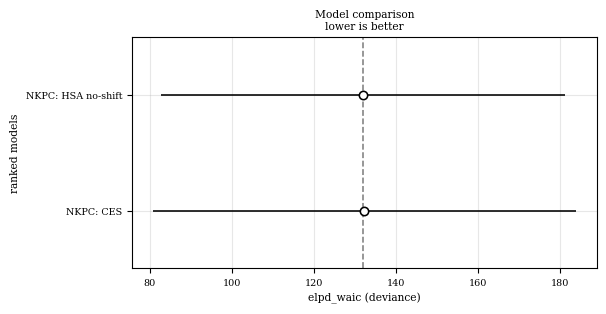

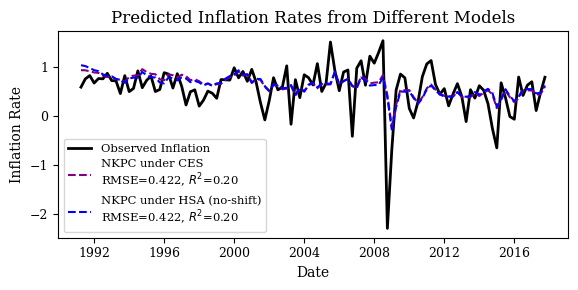

In [213]:
dict_idata = {
    'NKPC: CES':idata_0, 'NKPC: HSA no-shift':idata_1,
    }

df_waic = az.compare(dict_idata, var_name="pi_obs" ,ic='waic', scale='deviance')
df_loo = az.compare(dict_idata, var_name="pi_obs" ,ic='loo', scale='deviance')
scale = 3  # Scale factor for the figure size
az.plot_compare(df_waic, figsize=(6, 3))
# az.plot_compare(df_loo, figsize=(2.5*scale, 1*scale))

pi_pred_0  = idata_0.posterior["alpha"].mean().item() * pi_prev + (1 - idata_0.posterior["alpha"].mean().item()) * pi_expect + idata_0.posterior["kappa"].mean().item() * x_markup
pi_pred_1 = idata_1.posterior["alpha"].mean().item() * pi_prev + (1 - idata_1.posterior["alpha"].mean().item()) * pi_expect + idata_1.posterior["kappa"].mean().item() * x_markup - idata_1.posterior["theta"].mean().item() * N_hat_mean_1_m

# --- after you compute pi_pred_1…pi_pred_4 ---
def rmse(pred, obs):
    return np.sqrt(np.mean((pred - obs)**2))

def r2(pred, obs):
    ss_res = np.sum((obs - pred)**2)
    ss_tot = np.sum((obs - np.mean(obs))**2)
    return 1 - ss_res/ss_tot

# compute metrics
rmse0, r20 = rmse(pi_pred_0, pi), r2(pi_pred_0, pi)
rmse1, r21 = rmse(pi_pred_1, pi), r2(pi_pred_1, pi)

# Plotting the predicted inflation rates
plt.figure(figsize=(6, 3))
plt.plot(data["DATE"], pi, label="Observed Inflation", color='black', linewidth=2)
plt.plot(
    data["DATE"], pi_pred_0,
    label=f"NKPC under CES \nRMSE={rmse0:.3f}, $R^2$={r20:.2f}",
    color='purple', linestyle='--'
)
plt.plot(
    data["DATE"], pi_pred_1,
    label=f"NKPC under HSA (no-shift)\nRMSE={rmse1:.3f}, $R^2$={r21:.2f}",
    color='blue', linestyle='--'
)
plt.title("Predicted Inflation Rates from Different Models")
plt.xlabel("Date")
plt.ylabel("Inflation Rate")
plt.legend(loc="lower left", fontsize='small', framealpha=0.8)
plt.grid()
plt.tight_layout()
plt.show()

### Additional: Shift in the slope
$$
\pi_{t}=\alpha\pi_{t-1}+(1-\alpha)\mathbb{E}_{t}\pi_{t+1}+\underset{\kappa}{\underbrace{\frac{\zeta(z)-1}{\chi}}}x_{t}-\underset{\theta}{\underbrace{\frac{1-\rho(z)}{\rho(z)\chi}}}\hat{N}_{t}+v_{t},
$$
$$
N_{t}=\bar{N}_{t}+\hat{N}_{t},
$$
where
$$
\hat{N}_{t}=\rho_1 \hat{N}_{t-1}+\rho_2 \hat{N}_{t-2}+\epsilon_{t}
$$
$$
\bar{N}_{t}=n+\bar{N}_{t-1}+\eta_{t},
$$

$$\begin{cases}
case 1 & \Delta\kappa_{t}=\delta\Delta\bar{N}_{t}\\
case 2 & \Delta\kappa_{t}=\delta\Delta\bar{N}_{t}+e_{t}\\
\end{cases}$$
$$
v_t \sim \mathcal{N}(0, \sigma_{v}^2), \quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2), \quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2), \quad e_t \sim \mathcal{N}(0, \sigma_{e}^2)
$$

Estimated parameters are $\alpha$, $\kappa$, $\theta$, $\rho_1$, $\rho_2$, $n$, $\delta$, $\sigma_{\epsilon}$, $\sigma_{\eta}$, $\sigma_{e}$.



In [214]:
def model_case1(pi, pi_prev, pi_expect, x, N, l):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha",priors["alpha"])
    theta = numpyro.sample("theta", priors["theta"])
    # State equation (N) params
    r = numpyro.sample("r", dist.Uniform(-1,1))      # root for AR2
    p = numpyro.sample("p", dist.Uniform(0.1, 0.9))  # phi for AR2
    rho_1 = 2 * r * jnp.cos(jnp.pi * p)
    rho_2 = -r ** 2
    numpyro.deterministic("rho_1", rho_1) # Nhat AR1 coeff
    numpyro.deterministic("rho_2", rho_2) # Nhat AR2 coeff
    delta = numpyro.sample("delta", priors["delta"])
    n = numpyro.sample("n", priors["n"])
    # Sigma
    sigma_v  = numpyro.sample("sigma_v", priors["sigma_v"])      
    sigma_eta  = numpyro.sample("sigma_u", priors["sigma_eta"])    
    sigma_eps = numpyro.sample("sigma_eps", priors["sigma_eps"]) 
    # initial 
    bar_N_0  = numpyro.sample("bar_N_0", dist.Normal(N[0], 1)) # Nbar init
    hat_N_0  = numpyro.sample("hat_N_0", dist.Normal(0, 0.1))  # Nhat init
    hat_N_1  = numpyro.sample("hat_N_1", dist.Normal(0, 0.1))  # Nhat init
    kappa_0 = numpyro.sample("kappa_0", priors["kappa"])
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):
        Nbar_prev = carry[0]
        Nhat_prev_1 = carry[1]
        Nhat_prev_2 = carry[2]
        kappa_prev = carry[3]
        t = carry[4]
        # N 
        Nbar_t = numpyro.sample("Nbar", dist.Normal(n + Nbar_prev, sigma_eta))
        # N (Nbar + Nhat = observed N)
        N_hat_obs = N[t] - Nbar_t
        # cycle
        N_hat_pred = rho_1 * Nhat_prev_1 + rho_2 * Nhat_prev_2
        Nhat_t = numpyro.sample("Nhat_t", dist.Normal(N_hat_pred, sigma_eps), obs=N_hat_obs)
        numpyro.deterministic("Nhat", Nhat_t) 
        # kappa
        kappa_t = numpyro.deterministic("kappa", kappa_prev + delta * (Nbar_t - Nbar_prev))
        # pi
        pi_pred = alpha * pi_prev[t] + (1-alpha) * pi_expect[t] + kappa_t * x[t] - theta * Nhat_t
        numpyro.sample(f"pi_obs", numpyro.distributions.Normal(pi_pred, sigma_v), obs=pi[t])
        t = t + 1
        return [Nbar_t, Nhat_t, Nhat_prev_1, kappa_prev, t], None
    scan(transition, [bar_N_0, hat_N_0, hat_N_1, kappa_0 , t], timesteps)
def model_case2(pi, pi_prev, pi_expect, x, N, l):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha",priors["alpha"])
    theta = numpyro.sample("theta", priors["theta"])
    # State equation (N) params
    r = numpyro.sample("r", dist.Uniform(-1,1))      # root for AR2
    p = numpyro.sample("p", dist.Uniform(0.1, 0.9))  # phi for AR2
    rho_1 = 2 * r * jnp.cos(jnp.pi * p)
    rho_2 = -r ** 2
    numpyro.deterministic("rho_1", rho_1) # Nhat AR1 coeff
    numpyro.deterministic("rho_2", rho_2) # Nhat AR2 coeff
    delta = numpyro.sample("delta", priors["delta"])
    n = numpyro.sample("n", priors["n"])
    # Sigma
    sigma_v  = numpyro.sample("sigma_v", priors["sigma_v"])      
    sigma_eta  = numpyro.sample("sigma_u", priors["sigma_eta"])    
    sigma_eps = numpyro.sample("sigma_eps", priors["sigma_eps"]) 
    sigma_e = numpyro.sample("sigma_e", priors["sigma_e"]) 
    # initial 
    bar_N_0  = numpyro.sample("bar_N_0", dist.Normal(N[0], 1)) # Nbar init
    hat_N_0  = numpyro.sample("hat_N_0", dist.Normal(0, 0.1))  # Nhat init
    hat_N_1  = numpyro.sample("hat_N_1", dist.Normal(0, 0.1))  # Nhat init
    kappa_0 = numpyro.sample("kappa_0", priors["kappa"])
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):
        Nbar_prev = carry[0]
        Nhat_prev_1 = carry[1]
        Nhat_prev_2 = carry[2]
        kappa_prev = carry[3]
        t = carry[4]
        # N 
        Nbar_t = numpyro.sample("Nbar", dist.Normal(n + Nbar_prev, sigma_eta))
        # N (Nbar + Nhat = observed N)
        N_hat_obs = N[t] - Nbar_t
        # cycle
        N_hat_pred = rho_1 * Nhat_prev_1 + rho_2 * Nhat_prev_2
        Nhat_t = numpyro.sample("Nhat_t", dist.Normal(N_hat_pred, sigma_eps), obs=N_hat_obs)
        numpyro.deterministic("Nhat", Nhat_t) 
        # kappa
        kappa_t = numpyro.sample("kappa", dist.TruncatedNormal(loc = kappa_prev + delta * (Nbar_t - Nbar_prev), scale = sigma_e, low = 0))
        # pi
        pi_pred = alpha * pi_prev[t] + (1-alpha) * pi_expect[t] + kappa_t * x[t] - theta * Nhat_t
        numpyro.sample(f"pi_obs", numpyro.distributions.Normal(pi_pred, sigma_v), obs=pi[t])
        t = t + 1
        return [Nbar_t, Nhat_t, Nhat_prev_1, kappa_prev, t], None
    scan(transition, [bar_N_0, hat_N_0, hat_N_1, kappa_0 , t], timesteps)

In [215]:
print("case 1")
kernel = NUTS(model_case1, target_accept_prob=0.9)
mcmc_case1 = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc_case1.run(rng_keys, pi=pi,pi_prev=pi_prev, pi_expect=pi_expect, x=x, N=N, l=len(pi))
idata_case1 = az.from_numpyro(mcmc_case1)
diverging  = idata_case1.sample_stats["diverging"].values
ratio_div  = diverging.mean()        
print(f"case 1 : divergence ratio = {ratio_div:.4%}")

print("case 2")
kernel = NUTS(model_case2, target_accept_prob=0.9)
mcmc_case2 = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel", progress_bar=True)
mcmc_case2.run(rng_keys, pi=pi,pi_prev=pi_prev, pi_expect=pi_expect, x=x, N=N, l=len(pi))
idata_case2 = az.from_numpyro(mcmc_case2)
diverging  = idata_case2.sample_stats["diverging"].values
ratio_div  = diverging.mean()
print(f"case 2 : divergence ratio = {ratio_div:.4%}")

case 1


sample: 100%|██████████| 10000/10000 [13:10<00:00, 12.66it/s, 127 steps of size 2.81e-02. acc. prob=0.93]


case 1 : divergence ratio = 0.0000%
case 2


sample: 100%|██████████| 10000/10000 [07:29<00:00, 22.26it/s, 127 steps of size 3.77e-02. acc. prob=0.86]


case 2 : divergence ratio = 0.0000%


In [216]:
# Results
posterior_samples_case1 = mcmc_case1.get_samples()
N_bar_samples_case1 = posterior_samples_case1["Nbar"]   
N_bar_mean_case1 = np.mean(N_bar_samples_case1, axis=0)
N_bar_std_case1 = np.std(N_bar_samples_case1, axis=0)
N_bar_lower_case1 = N_bar_mean_case1 - 1.97 * N_bar_std_case1
N_bar_upper_case1 = N_bar_mean_case1 + 1.97 * N_bar_std_case1

N_hat_samples_case1 = posterior_samples_case1["Nhat"]
N_hat_mean_case1 = np.mean(N_hat_samples_case1, axis=0) 
N_hat_std_case1 = np.std(N_hat_samples_case1, axis=0)
N_hat_lower_case1 = N_hat_mean_case1 - 1.97 * N_hat_std_case1
N_hat_upper_case1 = N_hat_mean_case1 + 1.97 * N_hat_std_case1

kappa_samples_case1 = posterior_samples_case1["kappa"]
kappa_mean_case1 = np.mean(kappa_samples_case1, axis=0)
kappa_std_case1 = np.std(kappa_samples_case1, axis=0)
kappa_lower_case1 = kappa_mean_case1 - 1.97 * kappa_std_case1
kappa_upper_case1 = kappa_mean_case1 + 1.97 * kappa_std_case1

posterior_samples_case2 = mcmc_case2.get_samples()
N_bar_samples_case2 = posterior_samples_case2["Nbar"]
N_bar_mean_case2 = np.mean(N_bar_samples_case2, axis=0)
N_bar_std_case2 = np.std(N_bar_samples_case2, axis=0)
N_bar_lower_case2 = N_bar_mean_case2 - 1.97 * N_bar_std_case2
N_bar_upper_case2 = N_bar_mean_case2 + 1.97 * N_bar_std_case2

N_hat_samples_case2 = posterior_samples_case2["Nhat"]
N_hat_mean_case2 = np.mean(N_hat_samples_case2, axis=0)
N_hat_std_case2 = np.std(N_hat_samples_case2, axis=0)
N_hat_lower_case2 = N_hat_mean_case2 - 1.97 * N_hat_std_case2
N_hat_upper_case2 = N_hat_mean_case2 + 1.97 * N_hat_std_case2

kappa_samples_case2 = posterior_samples_case2["kappa"]
kappa_mean_case2 = np.mean(kappa_samples_case2, axis=0)
kappa_std_case2 = np.std(kappa_samples_case2, axis=0)
kappa_lower_case2 = kappa_mean_case2 - 1.97 * kappa_std_case2
kappa_upper_case2 = kappa_mean_case2 + 1.97 * kappa_std_case2

In [217]:
dict_idata = {
    'NKPC: CES':idata_0, 'NKPC: HSA no-shift':idata_1, 'NKPC: HSA case 1':idata_case1, 'NKPC: HSA shift with case 2': idata_case2,
    }
params = [
    "alpha", "kappa", "theta", "rho_1", "rho_2",  "n", "delta",
    ]
df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            if param in summary.index:
                row[param] = f"{summary.loc[param, 'mean']:.3f}"
            else:
                row[param] = "-"
        else:
            row[param] = "-"
    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)

,model,alpha,kappa,theta,rho_1,rho_2,n,delta
0,NKPC: CES,0.124,0.074,-,-,-,-,-
1,NKPC: HSA no-shift,0.125,0.076,0.461,1.707,-0.809,0.005,-
2,NKPC: HSA case 1,0.126,-,0.408,1.721,-0.821,0.004,0.494
3,NKPC: HSA shift with case 2,0.129,-,0.413,1.722,-0.822,0.004,0.495


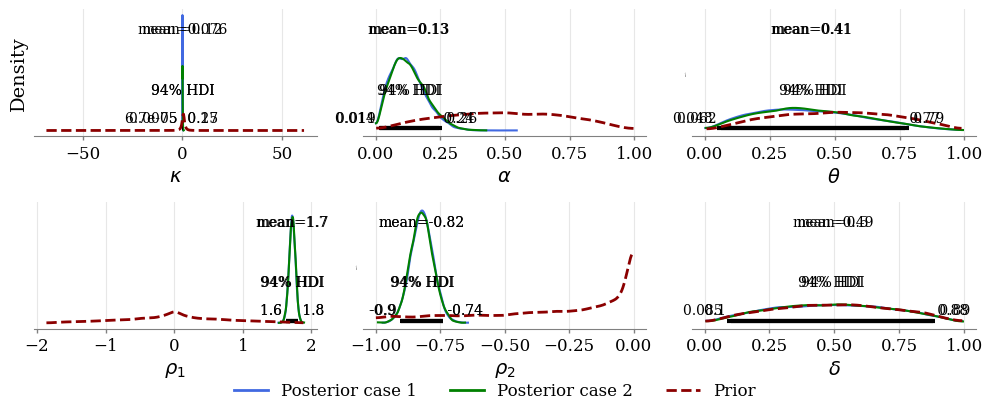

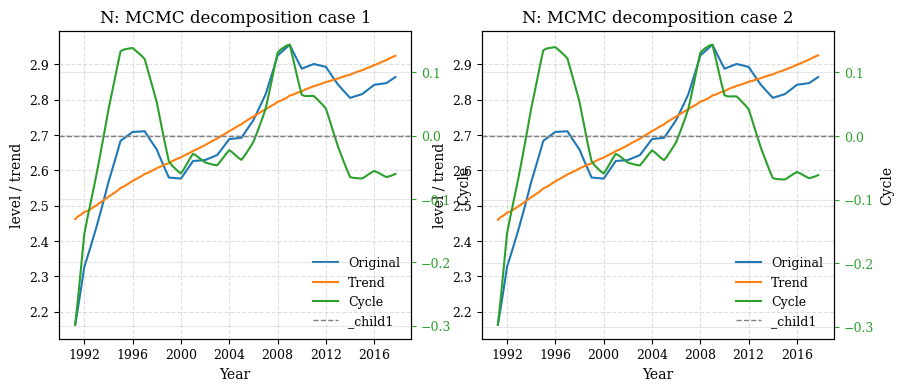

In [218]:
prior_pred_case1 = Predictive(model_case1, num_samples=10000)
prior_draws_case1 = prior_pred_case1(rng, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, x=x, N=N, l=len(pi))
params = ["kappa", "alpha", "theta", "rho_1", "rho_2", "delta"]
labels = [r"$\kappa$", r"$\alpha$", r"$\theta$", r"$\rho_{1}$", r"$\rho_{2}$", r"$\delta$"]
prior_dict_case1 = {k: prior_draws_case1[k] for k in params if k in prior_draws_case1}
idata_prior_case1 = az.from_dict(prior=prior_dict_case1)
fig, axes = plt.subplots(2, 3, figsize=(10, 4), sharey=True)
axes_flat = axes.ravel()
for ax, param, label in zip(axes_flat, params, labels):
    az.plot_posterior(
        idata_case1,
        var_names=[param],
        point_estimate="mean",
        hdi_prob=None,
        kind="kde",
        color="royalblue",
        ax=ax,
    )
    az.plot_posterior(
        idata_case2,
        var_names=[param],
        point_estimate="mean",
        hdi_prob=None,
        kind="kde",
        color="green",
        ax=ax,
    )
    az.plot_dist(
            idata_prior_case1.prior[param],
            ax=ax,
            color="darkred",
            fill_kwargs=None,
            plot_kwargs={"ls": "--", "lw": 2},
        )
    ax.set_title("")
    ax.set_xlabel(label, fontsize=14)
    ax.tick_params(axis="both", labelsize=12)

for i, ax in enumerate(axes_flat):
    ax.set_ylabel("Density", fontsize=14 if i % 5 == 0 else 0)
    if i % 2 == 1:
        ax.set_ylabel("")

for j in range(len(params), len(axes_flat)):
    axes_flat[j].axis("off")

legend_handles = [
    Line2D([0], [0], color="royalblue", lw=2, label="Posterior case 1"),
    Line2D([0], [0], color="green", lw=2, label="Posterior case 2"),
    Line2D([0], [0], color="darkred",  lw=2, ls="--", label="Prior"),
]
fig.legend(
    handles=legend_handles,
    fontsize=12,
    loc="lower center",
    ncol=3,                 
    frameon=False,
    bbox_to_anchor=(0.5, -0.05)  
)
plt.tight_layout()
plt.show()

scale = 2
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=False)
# First decomposition: no shift
plot_decomposition_ax(
    axes[0],
    data["DATE"], data["N"], N_bar_mean_case1, N_hat_mean_case1,
    "N: MCMC decomposition case 1", loc="lower right"
)
plot_decomposition_ax(
    axes[1],
    data["DATE"], data["N"], N_bar_mean_case2, N_hat_mean_case2,
    "N: MCMC decomposition case 2", loc="lower right"
)

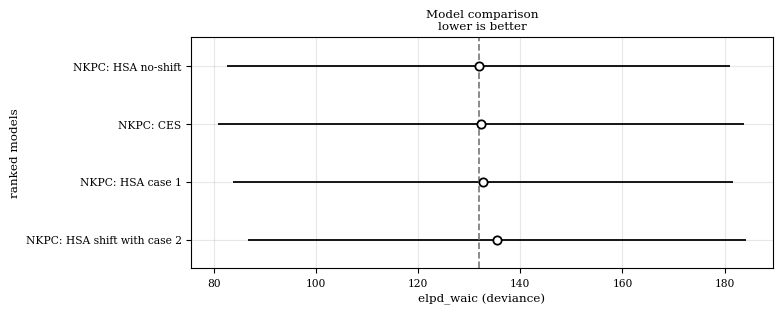

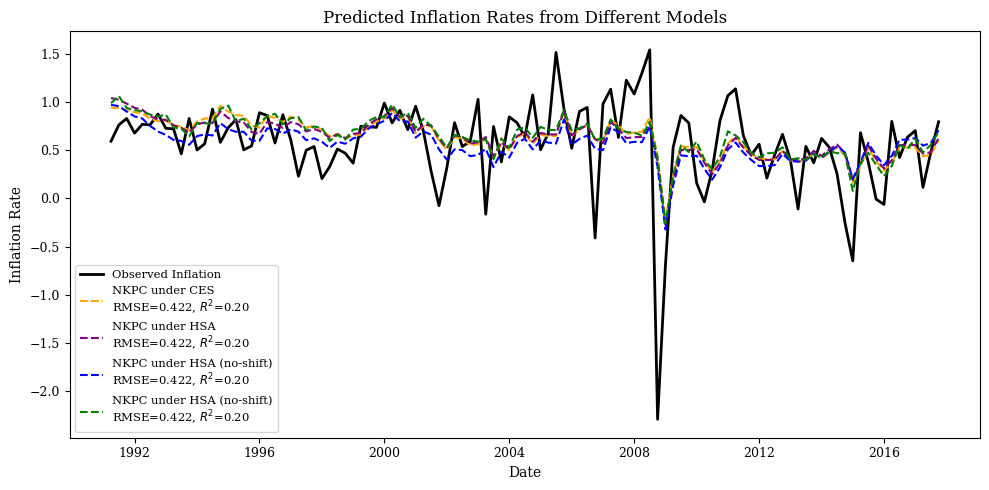

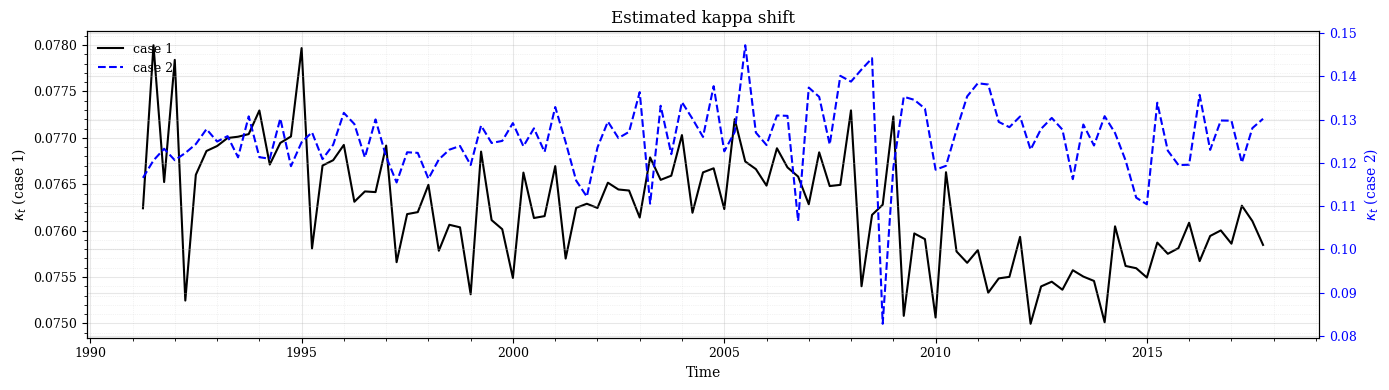

In [219]:
df_waic = az.compare(dict_idata, var_name="pi_obs" ,ic='waic', scale='deviance')
# df_loo = az.compare(dict_idata, var_name="pi_obs" ,ic='loo', scale='deviance')
scale = 3  # Scale factor for the figure size
az.plot_compare(df_waic, figsize=(2.5*scale, 1*scale))
# az.plot_compare(df_loo, figsize=(2.5*scale, 1*scale))

# --- after you compute pi_pred_1…pi_pred_4 ---
def rmse(pred, obs):
    return np.sqrt(np.mean((pred - obs)**2))

def r2(pred, obs):
    ss_res = np.sum((obs - pred)**2)
    ss_tot = np.sum((obs - np.mean(obs))**2)
    return 1 - ss_res/ss_tot

pi_pred_case1 = idata_case1.posterior["alpha"].mean().item() * pi_prev + (1 - idata_case1.posterior["alpha"].mean().item()) * pi_expect + kappa_mean_1 * x - idata_case1.posterior["theta"].mean().item() * N_hat_mean_1
pi_pred_case2 = idata_case2.posterior["alpha"].mean().item() * pi_prev + (1 - idata_case2.posterior["alpha"].mean().item()) * pi_expect + kappa_mean_2 * x - idata_case2.posterior["theta"].mean().item() * N_hat_mean_2
# compute metrics
rmse0_case1, r2_case1 = rmse(pi_pred_case1, pi), r2(pi_pred_case1, pi)
rmse1_case2, r2_case2 = rmse(pi_pred_case2, pi), r2(pi_pred_case2, pi)

# Plotting the predicted inflation rates
plt.figure(figsize=(10, 5))
plt.plot(data["DATE"], pi, label="Observed Inflation", color='black', linewidth=2)
plt.plot(
    data["DATE"], pi_pred_0,
    label=f"NKPC under CES \nRMSE={rmse0:.3f}, $R^2$={r20:.2f}",
    color='orange', linestyle='--'
)
plt.plot(
    data["DATE"], pi_pred_1,
    label=f"NKPC under HSA \nRMSE={rmse0:.3f}, $R^2$={r20:.2f}",
    color='purple', linestyle='--'
)
plt.plot(
    data["DATE"], pi_pred_case1,
    label=f"NKPC under HSA (no-shift)\nRMSE={rmse1:.3f}, $R^2$={r21:.2f}",
    color='blue', linestyle='--'
)
plt.plot(
    data["DATE"], pi_pred_case2,
    label=f"NKPC under HSA (no-shift)\nRMSE={rmse1:.3f}, $R^2$={r21:.2f}",
    color='green', linestyle='--'
)
plt.title("Predicted Inflation Rates from Different Models")
plt.xlabel("Date")
plt.ylabel("Inflation Rate")
plt.legend(loc="lower left", fontsize='small', framealpha=0.8)
plt.grid()
plt.tight_layout()
plt.show()

import matplotlib.dates as mdates
fig, ax_left = plt.subplots(1, 1, figsize=(14, 4))
ax_right = ax_left.twinx()
line_left,  = ax_left.plot(data["DATE"], kappa_mean_case1, label="case 1", color=colors[0])
line_right, = ax_right.plot(data["DATE"], kappa_mean_case2, label="case 2", color=colors[1], ls="--")
ax_left.set_title("Estimated kappa shift")
ax_left.set_xlabel("Time")
ax_left.set_ylabel(r"$\kappa_t$ (case 1)", color=colors[0])
ax_right.set_ylabel(r"$\kappa_t$ (case 2)", color=colors[1])
ax_left.tick_params(axis="y", colors=colors[0])
ax_right.tick_params(axis="y", colors=colors[1])
ax_left.minorticks_on()
ax_left.grid(which='major', linestyle='-', linewidth=0.75)
ax_left.grid(which='minor', linestyle=':', linewidth=0.5)
ax_left.xaxis.set_major_locator(mdates.YearLocator(5))
ax_left.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax_left.xaxis.set_minor_locator(mdates.YearLocator(1))
lines = [line_left, line_right]
labels = [l.get_label() for l in lines]
ax_left.legend(lines, labels, loc="upper left", frameon=False)

plt.tight_layout()
plt.show()
